**Detection of multiple diseases in Chest X-rays**

In this Notebook you can find the training, validation and testing process of the ResNet50V2 architecture

Kaggle Limit: GPU Quota limit: 30 hours / week | Resets, 9 hours

Suggs: change loss function to fit multiclass, fix class imbalance, change the activation layer?, do more metrics than just AUC (F1, precision, recall), deep auc optimization, regularization to stop the validation error from balllooning while the training error lessens (overfitting)





In [1]:
from google.colab import files
files.upload()  # upload kaggle.json file here

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d khanfashee/nih-chest-x-ray-14-224x224-resized

100% 2.30G/2.30G [01:01<00:00, 41.7MB/s]
100% 2.30G/2.30G [01:01<00:00, 40.3MB/s]


In [3]:
import zipfile
import os

# Unzip the dataset
zip_path = '/content/nih-chest-x-ray-14-224x224-resized.zip'  # Replace with the path to your downloaded zip file
unzip_path = '/content/dataset'  # The directory where you want to unzip the files
os.makedirs(unzip_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

In [4]:
try:
    inpath = "../content/dataset" #Kaggle
    print(os.listdir(inpath))
except FileNotFoundError:
    inpath = "./" #Local
    print(os.listdir(inpath))

['images-224', 'pretrained_model.h5', 'test_list_NIH.txt', 'Data_Entry_2017.csv', 'BBox_List_2017_Official_NIH.csv', 'train_val_list_NIH.txt']


In [5]:
import pandas as pd
data = pd.read_csv(inpath + '/Data_Entry_2017.csv',dtype=str)
print(f"The dimensions of the data set are: {data.shape}")
data.head()

The dimensions of the data set are: (112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,000,00000001,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,001,00000001,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,002,00000001,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,000,00000002,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,000,00000003,081Y,F,PA,2582,2991,0.143,0.143,NaN


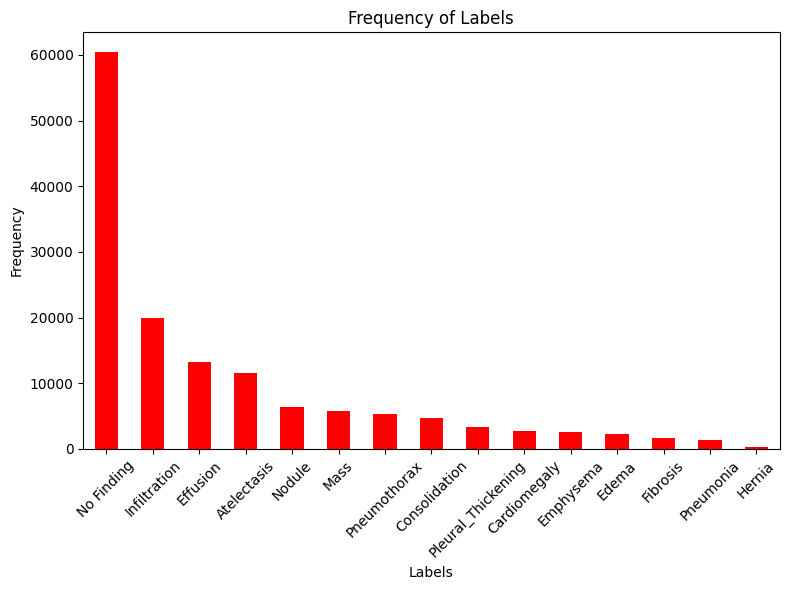

In [6]:
import matplotlib.pyplot as plt

# plotting freq of labels
labels_series = data['Finding Labels'].str.split('|', expand=True).stack()
label_counts = labels_series.value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='red')
plt.title('Frequency of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Define a function to convert age to int, handling errors
def convert_age_to_int(age_str):
    try:
        # Attempt to strip 'Y' and convert to integer
        return int(age_str.rstrip('Y'))
    except ValueError:
        # If conversion fails, return None or some default value
        return None

# Apply this function to each entry in the 'Patient Age' column
data['Patient Age'] = data['Patient Age'].apply(convert_age_to_int)

# Filter out rows where 'Patient Age' could not be converted to an integer
data = data[data['Patient Age'].notnull()]

# Further filter the data for ages less than 100
data = data[data['Patient Age'] < 100]

# Display the dimensions after filtering
print(f"The dimensions of the data set are: {data.shape}")

The dimensions of the data set are: (112077, 12)


In [8]:
data = data[['Image Index', 'Finding Labels']]

print(f"The dimensions of the data set are: {data.shape}")

The dimensions of the data set are: (112077, 2)


In [9]:
"""
We read all the paths of the images
"""
from glob import glob
import os

# Ensure you have the correct relative path from your current directory or use an absolute path
image_directory = '/content/dataset/images-224/images-224/*.png'
all_image_paths = {os.path.basename(x): x for x in glob(image_directory)}

print('Found images:', len(all_image_paths))

"""
We add the 'Path' column to the dataset
"""
data['Path'] = data['Image Index'].map(all_image_paths.get)

data.sample(5, random_state=3)

Found images: 112120


,Image Index,Finding Labels,Path
48039,00012163_002.png,No Finding,/content/dataset/images-224/images-224/0001216...
3031,00000800_001.png,Cardiomegaly|Effusion,/content/dataset/images-224/images-224/0000080...
49474,00012554_000.png,Nodule,/content/dataset/images-224/images-224/0001255...
92443,00023078_007.png,Emphysema,/content/dataset/images-224/images-224/0002307...
44802,00011514_027.png,No Finding,/content/dataset/images-224/images-224/0001151...


In [10]:
"""
Create a np array with all the single diseases
"""
import numpy as np
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [11]:
all_labels = np.delete(all_labels, np.where(all_labels == 'No Finding'))
print(f'Actual Type: {type(all_labels)}')

all_labels = [x for x in all_labels]
print(f'Final Type: {type(all_labels)}')

print(f'Disease: ({len(all_labels)}): {all_labels}')

Actual Type: <class 'numpy.ndarray'>
Final Type: <class 'list'>
Disease: (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [12]:
"""
We add a column for each disease
"""
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        # Add a column for each desease
        data[c_label] = data['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)

print(f"The dimensions of the dataset are: {data.shape}")
data.head()

The dimensions of the dataset are: (112077, 17)


,Image Index,Finding Labels,Path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,/content/dataset/images-224/images-224/0000000...,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,/content/dataset/images-224/images-224/0000000...,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,/content/dataset/images-224/images-224/0000000...,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,/content/dataset/images-224/images-224/0000000...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,/content/dataset/images-224/images-224/0000000...,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [13]:
label_counts = data['Finding Labels'].value_counts()
label_counts

No Finding                                                        60387
Infiltration                                                       9544
Atelectasis                                                        4210
Effusion                                                           3959
Nodule                                                             2706
                                                                  ...  
Edema|Infiltration|Mass|Nodule|Pneumonia                              1
Consolidation|Emphysema|Mass|Pneumothorax                             1
Atelectasis|Effusion|Fibrosis|Pneumothorax                            1
Atelectasis|Fibrosis|Infiltration|Nodule|Pneumothorax                 1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax        1
Name: Finding Labels, Length: 790, dtype: int64

In [14]:
data = data.groupby('Finding Labels').filter(lambda x : len(x)>11)

In [15]:
label_counts = data['Finding Labels'].value_counts()
print(label_counts.shape)
label_counts

(198,)


No Finding                                                      60387
Infiltration                                                     9544
Atelectasis                                                      4210
Effusion                                                         3959
Nodule                                                           2706
                                                                ...  
Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration       13
Cardiomegaly|Consolidation|Infiltration                            12
Effusion|Emphysema|Infiltration|Pneumothorax                       12
Consolidation|Infiltration|Pneumonia                               12
Atelectasis|Nodule|Pleural_Thickening                              12
Name: Finding Labels, Length: 198, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data,
                                               test_size = 0.20,
                                               random_state = 2018,
                                              )

# train_df, valid_df = train_test_split(train_and_valid_df,
                                      #test_size=0.30,
                                      #random_state=2018,
                                     #)

print(f'Training {train_df.shape[0]} Test: {test_df.shape[0]}')

Training 88341 Test: 22086


In [17]:
!pip install keras_preprocessing

from keras_preprocessing.image import ImageDataGenerator
base_generator = ImageDataGenerator(rescale=1./255)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [18]:
IMG_SIZE = (224, 224)
def flow_from_dataframe(image_generator, dataframe, batch_size):
    df_gen = image_generator.flow_from_dataframe(dataframe,
                                                 x_col='Path',
                                                 y_col=all_labels,
                                                 target_size=IMG_SIZE,
                                                 classes=all_labels,
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 shuffle=False,
                                                 batch_size=batch_size)

    return df_gen

In [19]:
train_gen = flow_from_dataframe(image_generator=base_generator,
                                dataframe= train_df,
                                batch_size = 32)

#valid_gen = flow_from_dataframe(image_generator=base_generator,
                                #dataframe=valid_df,
                                #batch_size = 32)

test_gen = flow_from_dataframe(image_generator=base_generator,
                               dataframe=test_df,
                               batch_size = 32)

/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:219: UserWarning: `classes` will be ignored given the class_mode="raw"
  warnings.warn('`classes` will be ignored given the class_mode="{}"'


Found 88341 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:219: UserWarning: `classes` will be ignored given the class_mode="raw"
  warnings.warn('`classes` will be ignored given the class_mode="{}"'


Found 22086 validated image filenames.


In [20]:
train_x, train_y = next(train_gen)
print(f"Dimension of the image: {train_x[1].shape}")
print(f"Diseases vector: {train_y[1]}")

Dimension of the image: (224, 224, 3)
Diseases vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [21]:
from keras.layers import Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.layers import Dense
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Model

input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

base_model = ResNet50V2(include_top=False, input_tensor=img_input, input_shape=input_shape,
                         pooling="avg", weights='imagenet')

for layer in base_model.layers[:-10]:
    layer.trainable = False

x = base_model.output
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)
model = Model(inputs=img_input, outputs=predictions)

94668760/94668760 [==============================] - 3s 0us/step


In [22]:
from contextlib import redirect_stdout

with open('model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [23]:
from keras.callbacks import ModelCheckpoint
model_train = model
output_weights_name='weights.h5'
checkpoint = ModelCheckpoint(
             output_weights_name,
             save_weights_only=True,
             save_best_only=True,
             verbose=1,
            )

In [24]:
import keras.backend as kb
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score
import shutil
import warnings
import json

class MultipleClassAUROC(Callback):
    """
    Monitor mean AUROC and update model
    """
    def __init__(self, generator, class_names, weights_path, stats=None):
        super(Callback, self).__init__()
        self.generator = generator
        self.class_names = class_names
        self.weights_path = weights_path
        self.best_weights_path = os.path.join(
            os.path.split(weights_path)[0],
            f"best_{os.path.split(weights_path)[1]}",
        )
        self.best_auroc_log_path = os.path.join(
            os.path.split(weights_path)[0],
            "best_auroc.log",
        )
        self.stats_output_path = os.path.join(
            os.path.split(weights_path)[0],
            ".training_stats.json"
        )
        # for resuming previous training
        if stats:
            self.stats = stats
        else:
            self.stats = {"best_mean_auroc": 0}

        # aurocs log
        self.aurocs = {}
        for c in self.class_names:
            self.aurocs[c] = []

        # store the f1, precision, and recall
        self.f1_scores = {}
        self.precision_scores = {}
        self.recall_scores = {}
        for c in self.class_names:
            self.f1_scores[c] = []
            self.precision_scores[c] = []
            self.recall_scores[c] = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Calculate the average of the ROC Curves and save the best set of weights
        according to this metric
        """
        print("\n*********************************")
        self.stats["lr"] = float(kb.eval(self.model.optimizer.lr))
        print(f"Learning Rate actual: {self.stats['lr']}")

        """
        y_hat shape: (#examples, len(labels))
        y: [(#examples, 1), (#examples, 1) ... (#examples, 1)]
        """
        y_hat = self.model.predict(self.generator,steps=self.generator.n/self.generator.batch_size)
        y = self.generator.labels

        print(f"*** epoch#{epoch + 1} ROC Curves Training Phase ******")
        current_auroc = []
        for i in range(len(self.class_names)):
            try:
                score = roc_auc_score(y[:, i], y_hat[:, i])
            except ValueError:
                score = 0
            self.aurocs[self.class_names[i]].append(score)
            current_auroc.append(score)
            print(f"{i+1}. {self.class_names[i]}: {score}")
        print("*********************************")

        mean_auroc = np.mean(current_auroc)
        print(f"Average ROC Curves: {mean_auroc}")
        if mean_auroc > self.stats["best_mean_auroc"]:
            print(f"Updating ROC Curves result from: {self.stats['best_mean_auroc']} to {mean_auroc}")

            # 1. copy best model
            shutil.copy(self.weights_path, self.best_weights_path)

            # 2. update log file
            print(f"Updating log file: {self.best_auroc_log_path}")
            with open(self.best_auroc_log_path, "a") as f:
                f.write(f"(epoch#{epoch + 1}) auroc: {mean_auroc}, lr: {self.stats['lr']}\n")

            # 3. write stats output, this is used for resuming the training
            with open(self.stats_output_path, 'w') as f:
                json.dump(self.stats, f)

            print(f"Updating weights group: {self.weights_path} -> {self.best_weights_path}")
            self.stats["best_mean_auroc"] = mean_auroc
            print("*********************************")

        print("\n*********************************")
        print(f"*** epoch#{epoch + 1} Metrics Training Phase ***")

        current_f1 = []
        current_precision = []
        current_recall = []

        for i in range(len(self.class_names)):
            try:
                score_precision = precision_score(y[:, i], y_hat[:, i] > 0.5, zero_division=1)
                score_recall = recall_score(y[:, i], y_hat[:, i] > 0.5, zero_division=1)
                score_f1 = f1_score(y[:, i], y_hat[:, i] > 0.5, zero_division=1)
            except ValueError:
                score_f1 = 0
                score_precision = 0
                score_recall = 0

            self.f1_scores[self.class_names[i]].append(score_f1)
            self.precision_scores[self.class_names[i]].append(score_precision)
            self.recall_scores[self.class_names[i]].append(score_recall)

            current_f1.append(score_f1)
            current_precision.append(score_precision)
            current_recall.append(score_recall)

            print(f"{i+1}. {self.class_names[i]}: F1 - {score_f1}, Precision - {score_precision}, Recall - {score_recall}")

        mean_f1 = np.mean(current_f1)
        mean_precision = np.mean(current_precision)
        mean_recall = np.mean(current_recall)

        print(f"F1: {mean_f1}, Precision: {mean_precision}, Recall: {mean_recall}")

        return

In [25]:
training_stats = {}
auroc = MultipleClassAUROC(
    generator=test_gen,
    class_names=all_labels,
    weights_path=output_weights_name,
    stats=training_stats
)

In [26]:
from keras.optimizers import Adam
initial_learning_rate=1e-4
optimizer = Adam(learning_rate=initial_learning_rate)
model_train.compile(optimizer=optimizer, loss="binary_crossentropy")

In [27]:
from keras.callbacks import TensorBoard, ReduceLROnPlateau
#TODO - VALIDATE THE LOGS OUTPUT
logs_base_dir = '../working/'
patience_reduce_lr=2
min_lr=1e-8
callbacks = [
            checkpoint,
            TensorBoard(log_dir=os.path.join(logs_base_dir, "logs")),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience_reduce_lr,
                              verbose=1, mode="min", min_lr=min_lr),
            auroc,
        ]

In [28]:
epochs = 10
fit_history = model.fit(
    x=train_gen,
    steps_per_epoch=train_gen.n // train_gen.batch_size,  # Make sure to use integer division
    epochs=epochs,
    validation_data=test_gen,
    validation_steps=test_gen.n // test_gen.batch_size,  # Make sure to use integer division
    callbacks=callbacks,
    shuffle=False  # Note: shuffling is typically done in the generator
)

Epoch 1/10
2760/2760 [==============================] - ETA: 0s - loss: 0.2059
Epoch 1: val_loss improved from inf to 0.15797, saving model to weights.h5

*********************************
Learning Rate actual: 9.999999747378752e-05
690/690 [==============================] - 60s 86ms/step
*** epoch#1 ROC Curves Training Phase ******
1. Atelectasis: 0.7420109338473186
2. Cardiomegaly: 0.755544952386985
3. Consolidation: 0.7429087196644896
4. Edema: 0.8429424181495887
5. Effusion: 0.8251067864690356
6. Emphysema: 0.7762214719052434
7. Fibrosis: 0.6828077214779366
8. Hernia: 0.6425338895065413
9. Infiltration: 0.671511931284708
10. Mass: 0.6887869510370146
11. Nodule: 0.628425494435235
12. Pleural_Thickening: 0.69839867533039
13. Pneumonia: 0.6275133665413307
14. Pneumothorax: 0.7936813294152243
*********************************
Average ROC Curves: 0.7227424743893602
Updating ROC Curves result from: 0 to 0.7227424743893602
Updating log file: best_auroc.log
Updating weights group: weights.

In [ ]:
# saving to google drive for future use begins here
#model.save_weights('model_weights.h5')
model.save('full_model.h5')

In [ ]:
import pickle
with open('history.pkl', 'wb') as file:
    pickle.dump(fit_history, file)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pickle
# saving callbacks
file_path = '/content/gdrive/My Drive/School/385Project/history2.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(fit_history, file)

In [ ]:
# saving models and weights
model.save('/content/gdrive/My Drive/School/385Project/model2.h5')
model.save_weights('/content/gdrive/My Drive/School/385Project/weights2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# saving best_weights and full_model
import shutil

# Define source and destination paths
source_weights = '/content/best_weights.h5'  # Replace with your source file path in Colab
destination_weights = '/content/gdrive/My Drive/School/385Project/best_weights2.h5'  # Replace with your Drive destination path

source_model = '/content/full_model.h5'
destination_model = '/content/gdrive/My Drive/School/385Project/full_model2.h5'

# Copy the weights file to Google Drive
shutil.copyfile(source_weights, destination_weights)
shutil.copyfile(source_model, destination_model)

'/content/gdrive/My Drive/School/385Project/full_model2.h5'

In [ ]:
import shutil

# Define source and destination paths
source_auroc = '/content/best_auroc.log'  # Replace with your source file path in Colab
destination_auroc = '/content/gdrive/My Drive/School/385Project/best_auroc2.log'  # Replace with your Drive destination path

source_modelsum = '/content/model_summary.txt'
destination_modelsum = '/content/gdrive/My Drive/School/385Project/model_summary2.txt'

# Copy the weights file to Google Drive
shutil.copyfile(source_auroc, destination_auroc)
shutil.copyfile(source_modelsum, destination_modelsum)

'/content/gdrive/My Drive/School/385Project/model_summary2.txt'

In [ ]:
from tensorflow.keras.models import load_model
model.load_weights('model_weights.h5')
model = load_model('full_model.h5')

In [ ]:
# resume on epoch 13
new_model.fit(train_data_for_remaining_epochs, initial_epoch=13, epochs=20)

In [ ]:
model.save('/content.h5')
import json

# Convert the history.history dict to a JSON file
with open('/content.json', 'w') as f:
    json.dump(fit_history.history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TypeError: ignored

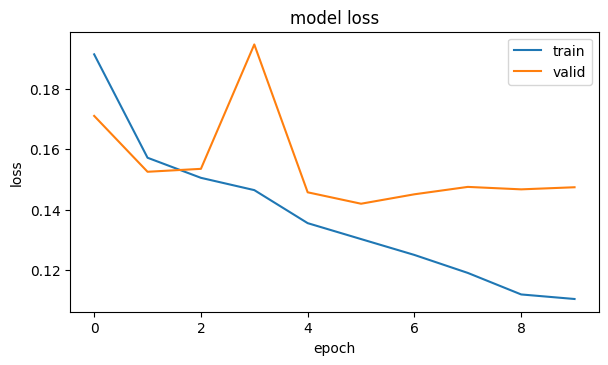

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1, figsize = (15,8))

plt.subplot(222)
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

In [ ]:
pred_y = model.predict_generator(test_gen, steps=test_gen.n/test_gen.batch_size, verbose = True)

<ipython-input-43-e047ab9d15fe>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_y = model.predict_generator(test_gen, steps=test_gen.n/test_gen.batch_size, verbose = True)


690/690 [==============================] - 62s 90ms/step


In [ ]:
test_gen.reset()
test_x, test_y = next(test_gen)
print(f"Vector de enfermedades: {test_y[1]}")
print(f"Vector de enfermedades producto de la predicción: {pred_y[2]}")

Vector de enfermedades: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Vector de enfermedades producto de la predicción: [1.0893461e-01 2.9583357e-03 6.1336793e-02 1.2626233e-02 5.9037838e-02
 4.2334950e-04 6.9201161e-04 4.3573593e-05 3.3745438e-01 2.4883980e-03
 6.7987558e-03 2.8492550e-03 7.5955791e-03 1.1299191e-03]


In [ ]:
# Get the class with the highest probability as the predicted class
predicted_classes = np.argmax(pred_y, axis=1)

# Get the true classes
true_classes = np.argmax(test_y, axis=1)

predicted_classes.shape
test_y.shape

(32, 14)

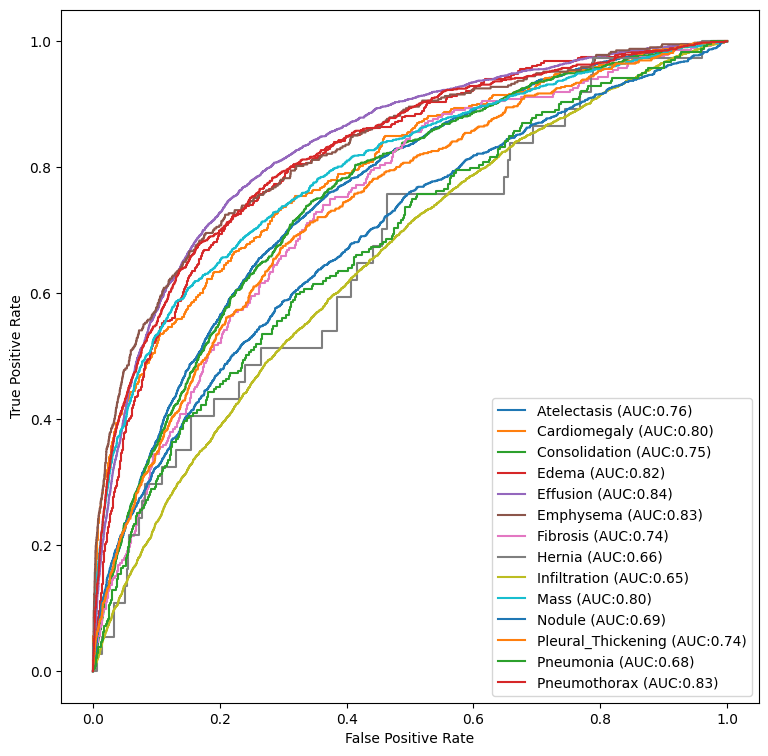

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
test_gen.reset()
test_x, test_y = next(test_gen)
# Space
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    #Points to graph
    fpr, tpr, thresholds = roc_curve(test_gen.labels[:,idx].astype(int), pred_y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))

#convention
c_ax.legend()

#Labels
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

# Save as a png
fig.savefig('barely_trained_net.png')

In [ ]:
from sklearn.metrics import roc_auc_score
# ROC AUC
auc = roc_auc_score(test_gen.labels, pred_y)
print('ROC AUC: %f' % auc)

ROC AUC: 0.755145


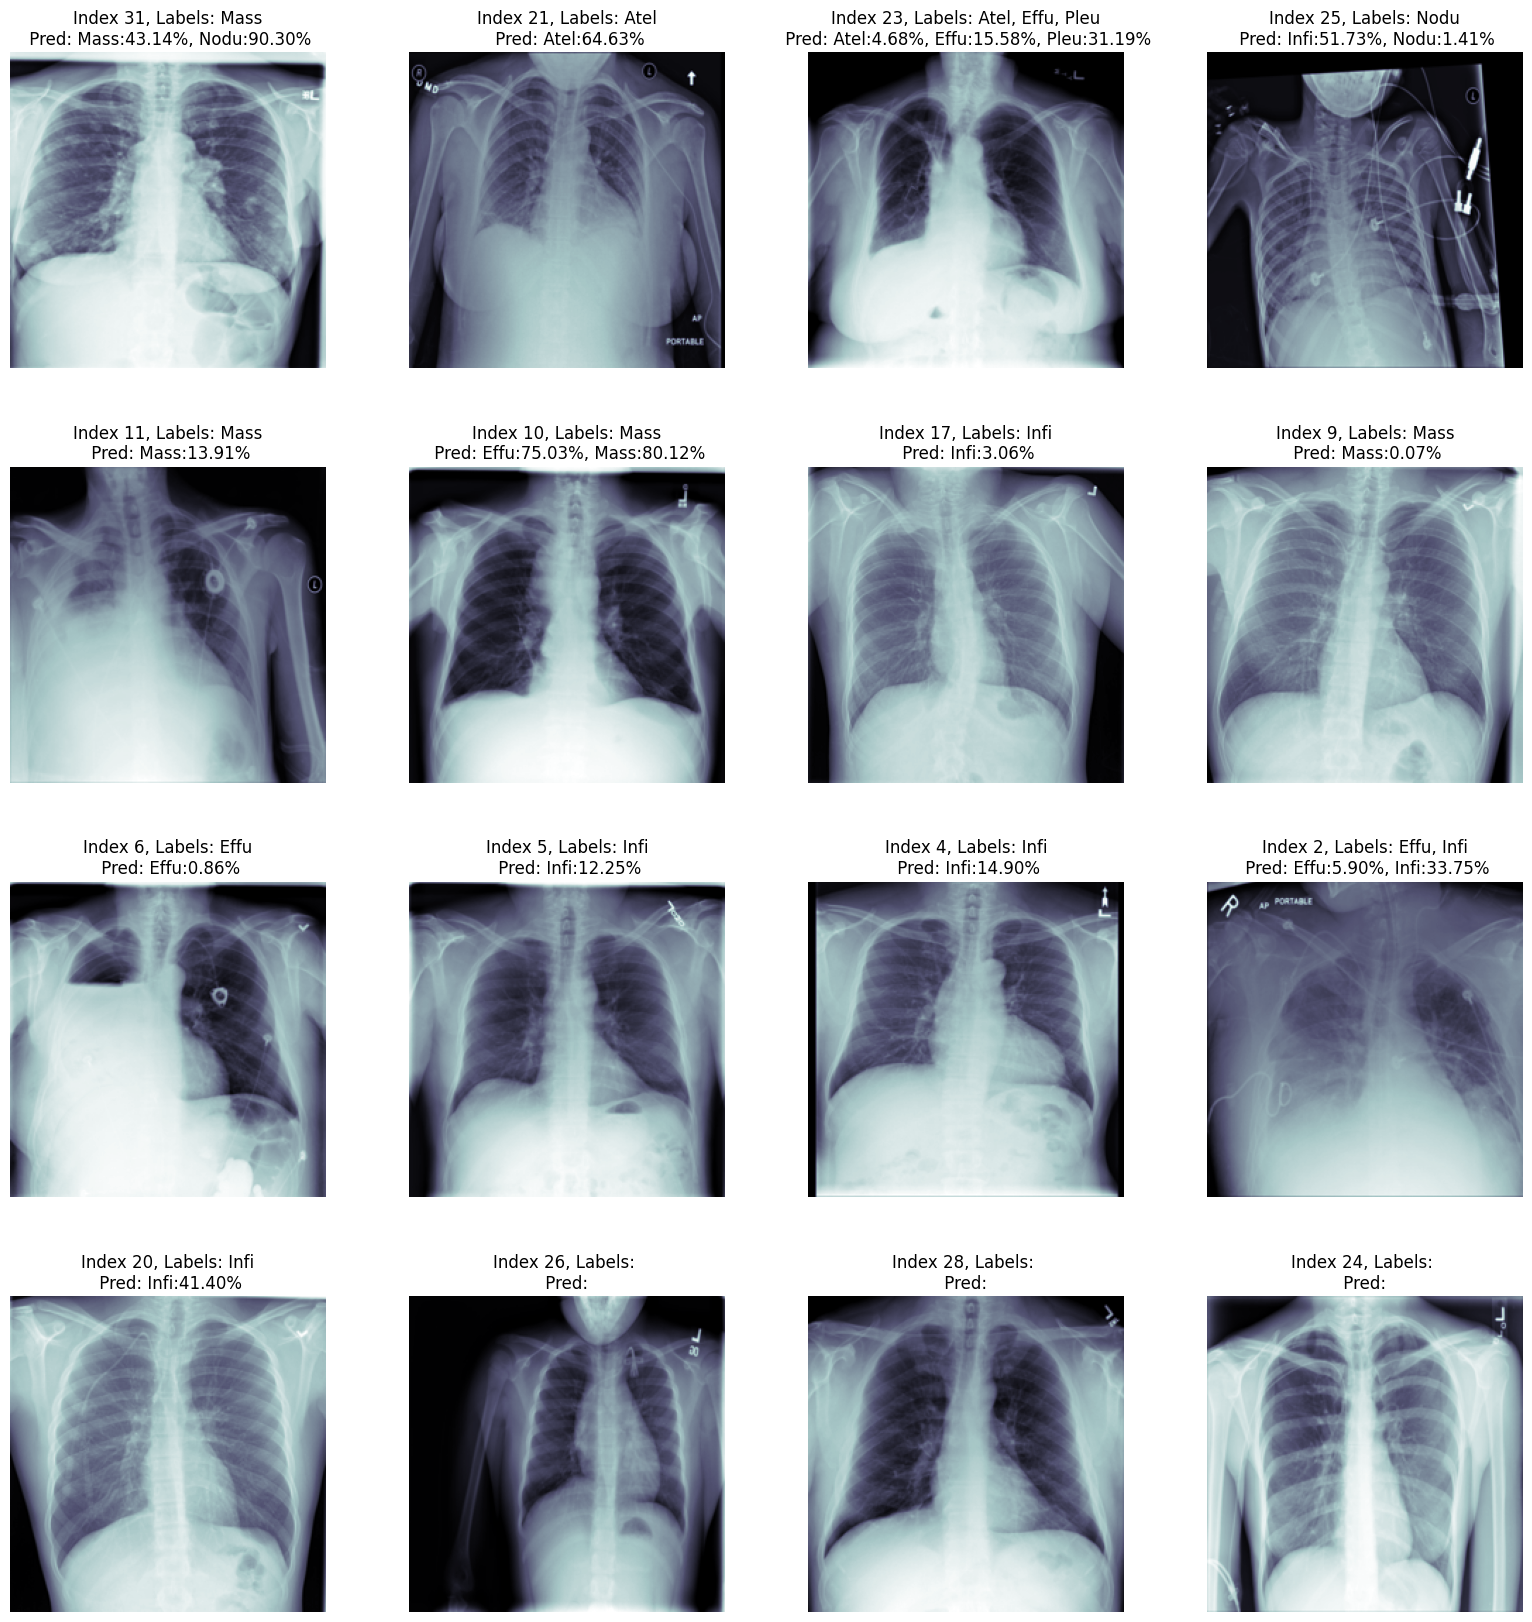

In [ ]:
sickest_idx = np.argsort(np.sum(test_y, 1)<1)

#Space of images
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))

# Padding
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
counter = 0

for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):

    # Image show
    c_ax.imshow(test_x[idx, :,:,0], cmap = 'bone')

    stat_str = [n_class[:4] for n_class, n_score in zip(all_labels, test_y[idx]) if n_score>0.5]

    # Building the labels
    pred_str = [f'{n_class[:4]}:{p_score*100:.2f}%'
                for n_class, n_score, p_score
                in zip(all_labels,test_y[idx],pred_y[idx])
                if (n_score>0.5) or (p_score>0.5)]

    c_ax.set_title(f'Index {idx}, Labels: '+', '.join(stat_str)+'\n Pred: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')